In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("words_glasgow.csv", skipinitialspace=True)

In [3]:
intp = df['web_corpus_freq'].interpolate(method="linear")
df['web_corpus_freq_interp_linear'] = df['web_corpus_freq'].fillna(intp)

#remove useless variables
column2drop = ["word", 'web_corpus_freq']
df.drop(column2drop, axis=1, inplace=True)

In [4]:
# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

##### Decision Tree Visualization ###
#from sklearn.tree import export_graphviz
from sklearn import tree # export_graphviz() method
import pydotplus # viz stuff
from IPython.display import Image # viz stuff
####################################

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from collections import Counter
from collections import defaultdict

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

In [5]:
# Hold-out
attributes = [col for col in df.columns if col != 'polysemy']
X = df[attributes].values
y = df['polysemy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Unbalanced decision tree

In [6]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )

clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=16)

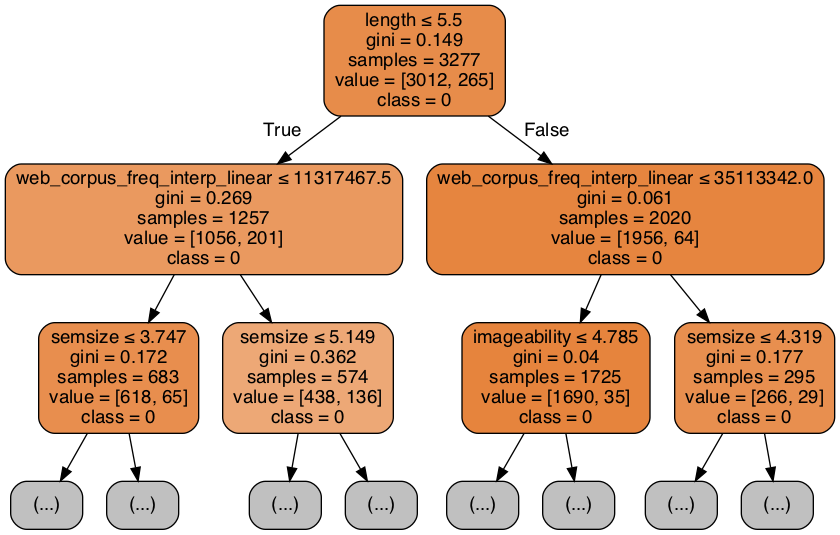

In [7]:
dot_data = tree.export_graphviz (clf, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=2)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [8]:
y_pred_DT = clf.predict(X_test)

In [9]:
print( classification_report(y_test, y_pred_DT) )

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1291
           1       0.22      0.07      0.11       114

    accuracy                           0.90      1405
   macro avg       0.57      0.52      0.53      1405
weighted avg       0.87      0.90      0.88      1405



# Unbalanced random forest

In [10]:
rfcl= RandomForestClassifier( criterion="gini",
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )
rfcl.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=15, min_samples_split=16)

In [11]:
y_pred_RF = rfcl.predict(X_test)

In [12]:
print( classification_report(y_test, y_pred_RF) )

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1291
           1       0.00      0.00      0.00       114

    accuracy                           0.92      1405
   macro avg       0.46      0.50      0.48      1405
weighted avg       0.84      0.92      0.88      1405



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Unbalanced KNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [14]:
y_pred_KNN = knn.predict(X_test)

In [15]:
print( classification_report(y_test, y_pred_KNN) )

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1291
           1       0.00      0.00      0.00       114

    accuracy                           0.92      1405
   macro avg       0.46      0.50      0.48      1405
weighted avg       0.84      0.92      0.88      1405



# How to choose the best parameters

In [16]:
#Changing input values (depth, leafs and splits) we'll find different solutions
param_list = {'max_depth': [None],
             'min_samples_split': np.arange(2, 20, 1).tolist(),
             'min_samples_leaf': np.arange(1, 20, 1).tolist()
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1')
grid_search.fit(X_train, y_train)

res = grid_search.cv_results_

In [17]:
grid_search.best_estimator_

DecisionTreeClassifier(min_samples_leaf=6, min_samples_split=12)

In [18]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 12}

In [19]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [20]:
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.225 (std: 0.037)
Parameters: {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.224 (std: 0.038)
Parameters: {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.221 (std: 0.034)
Parameters: {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 7}



# Oversample

In [21]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
# define dataset
# summarize class distribution
print(Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.3)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_over))

Counter({0: 4303, 1: 379})
Counter({0: 3012, 1: 903})


# Decision tree over

In [22]:
clf_over = DecisionTreeClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )

clf_over.fit(X_over, y_over)

DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=16)

In [23]:
y_pred_CLFov = clf.predict(X_test)

In [24]:
print( classification_report(y_test, y_pred_CLFov))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1291
           1       0.22      0.07      0.11       114

    accuracy                           0.90      1405
   macro avg       0.57      0.52      0.53      1405
weighted avg       0.87      0.90      0.88      1405



# Random forest over

In [25]:
rfcl_over= RandomForestClassifier( criterion="entropy",
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )
rfcl_over.fit(X_over, y_over)

RandomForestClassifier(criterion='entropy', min_samples_leaf=15,
                       min_samples_split=16)

In [26]:
y_pred_RFov = rfcl_over.predict(X_test)

In [27]:
print (classification_report(y_test, y_pred_RFov))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1291
           1       0.38      0.16      0.22       114

    accuracy                           0.91      1405
   macro avg       0.65      0.57      0.59      1405
weighted avg       0.88      0.91      0.89      1405



# KNN over

In [28]:
KNN_over = KNeighborsClassifier(n_neighbors=10)
KNN_over.fit(X_over, y_over)

KNeighborsClassifier(n_neighbors=10)

In [29]:
y_pred_KNNov = KNN_over.predict(X_test)

In [30]:
print (classification_report(y_test, y_pred_KNNov))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1291
           1       0.14      0.18      0.16       114

    accuracy                           0.85      1405
   macro avg       0.53      0.54      0.54      1405
weighted avg       0.86      0.85      0.85      1405



# Decision tree smote

In [31]:
sm = SMOTE(random_state=42, sampling_strategy=0.3)
X_res_sm, y_res_sm = sm.fit_resample(X_train, y_train)

In [32]:
clf_smote = DecisionTreeClassifier( criterion="gini",
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )
clf_smote.fit(X_res_sm, y_res_sm)

DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=16)

In [33]:
y_pred_CLFsm = clf_smote.predict(X_test)

In [34]:
print (classification_report(y_test, y_pred_CLFsm))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1291
           1       0.29      0.25      0.26       114

    accuracy                           0.89      1405
   macro avg       0.61      0.60      0.60      1405
weighted avg       0.88      0.89      0.89      1405



# Random forest smote

In [35]:
rfcl_smote= RandomForestClassifier( criterion="entropy",
                             max_depth=None,
                             min_samples_split=16,
                             min_samples_leaf=15,
                            )
rfcl_smote.fit(X_res_sm, y_res_sm)

RandomForestClassifier(criterion='entropy', min_samples_leaf=15,
                       min_samples_split=16)

In [36]:
y_pred_RFCLsm = rfcl_smote.predict(X_test)

In [37]:
print (classification_report(y_test, y_pred_RFCLsm))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1291
           1       0.30      0.19      0.23       114

    accuracy                           0.90      1405
   macro avg       0.61      0.58      0.59      1405
weighted avg       0.88      0.90      0.89      1405



# KNN smote

In [38]:
KNN_sm = KNeighborsClassifier(n_neighbors=15)
KNN_sm.fit(X_res_sm, y_res_sm)

KNeighborsClassifier(n_neighbors=15)

In [39]:
y_pred_KNNsm = KNN_sm.predict(X_test)

In [40]:
print (classification_report(y_test, y_pred_KNNsm))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1291
           1       0.14      0.14      0.14       114

    accuracy                           0.86      1405
   macro avg       0.53      0.53      0.53      1405
weighted avg       0.86      0.86      0.86      1405



# ROC curves

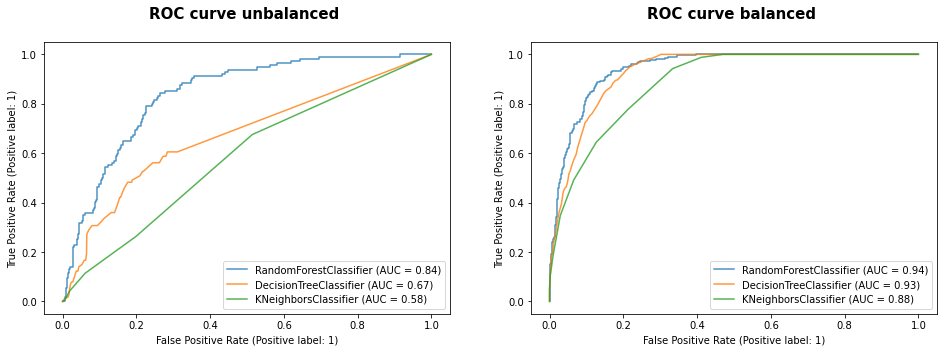

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

rfc_disp = RocCurveDisplay.from_estimator(rfcl, X_test, y_test, ax=ax1, alpha=0.8)
rfc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1, alpha=0.8)
rfc_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax1, alpha=0.8)

rfc_disp_over = RocCurveDisplay.from_estimator(rfcl_smote, X_over, y_over, ax=ax2, alpha=0.8)
rfc_disp_over = RocCurveDisplay.from_estimator(clf_smote, X_over, y_over, ax=ax2, alpha=0.8)
rfc_disp_over = RocCurveDisplay.from_estimator(KNN_over, X_over, y_over, ax=ax2, alpha=0.8)

ax1.set_title("ROC curve unbalanced \n", fontsize = 15, fontweight='bold')
ax2.set_title("ROC curve balanced \n", fontsize= 15, fontweight='bold')

plt.show()

# Confusion Matrix

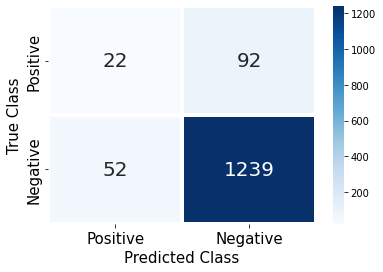

In [42]:
cf = confusion_matrix(y_test, y_pred_RFCLsm, labels=[1,0])

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cf, annot=True, annot_kws={"size": 20}, fmt='d', linewidths=4, cmap="Blues")

ax.set_xticklabels(['Positive','Negative'], fontsize=15)
ax.set_xlabel('Predicted Class', fontsize=15)
ax.set_yticklabels(['Positive','Negative'], fontsize=15)
ax.set_ylabel('True Class', fontsize=15)
plt.show()